### 목표 : 다중 속성/피쳐를 기반으로 수치값 예측
- 데이터 : fish.csv
- 피쳐 : 4개 Length, Diagonal, Height, Width
- 타겟 : 수치값 Weight
- 학습유형 : 지도학습 + 회귀
- 알고리즘 : 데이터를 확인 후 결정

(1) 모듈 로딩 및 데이터 준비 <hr>

In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [319]:
# 데이터 준비
data_file = '../data/fish.csv'

# Bream행만 추출 => 35개 행만 추출
dataDF = pd.read_csv(data_file, nrows = 35, usecols = [1, 2, 3, 4, 5])
dataDF

Weight  Length  Diagonal   Height   Width
0      242    25.4      30.0  11.5200  4.0200
1      290    26.3      31.2  12.4800  4.3056
2      340    26.5      31.1  12.3778  4.6961
3      363    29.0      33.5  12.7300  4.4555
4      430    29.0      34.0  12.4440  5.1340
5      450    29.7      34.7  13.6024  4.9274
6      500    29.7      34.5  14.1795  5.2785
7      390    30.0      35.0  12.6700  4.6900
8      450    30.0      35.1  14.0049  4.8438
9      500    30.7      36.2  14.2266  4.9594
10     475    31.0      36.2  14.2628  5.1042
11     500    31.0      36.2  14.3714  4.8146
12     500    31.5      36.4  13.7592  4.3680
13     340    32.0      37.3  13.9129  5.0728
14     600    32.0      37.2  14.9544  5.1708
15     600    32.0      37.2  15.4380  5.5800
16     700    33.0      38.3  14.8604  5.2854
17     700    33.0      38.5  14.9380  5.1975
18     610    33.5      38.6  15.6330  5.1338
19     650    33.5      38.7  14.4738  5.7276
20     575    34.0      39.5  15.1285  5.5695
21     685    34.0      39.2  15.9936  5.3704
22     620    34.5      39.7  15.5227  5.2801
23     680    35.0      40.6  15.4686  6.1306
24     700    35.0      40.5  16.2405  5.5890
25     725    35.0      40.9  16.3600  6.0532
26     720    35.0      40.6  16.3618  6.0900
27     714    36.0      41.5  16.5170  5.8515
28     850    36.0      41.6  16.8896  6.1984
29    1000    37.0      42.6  18.9570  6.6030
30     920    38.5      44.1  18.0369  6.3063
31     955    38.5      44.0  18.0840  6.2920
32     925    39.5      45.3  18.7542  6.7497
33     975    41.0      45.9  18.6354  6.7473
34     950    41.0      46.5  17.6235  6.3705

In [320]:
# 기본정보
dataDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Weight    35 non-null     int64  
 1   Length    35 non-null     float64
 2   Diagonal  35 non-null     float64
 3   Height    35 non-null     float64
 4   Width     35 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 1.5 KB


(2) 데이터 확인 <hr>

- 타겟과 피쳐 사이의 관계 => 상관계수, 시각화

In [321]:
# 함수기능 : 피처와 타겟과의 관계 정도를 시각화 및 수치값으로 표기 및 출력
# 매개변수 : 행수, 열수, 타겟, 피쳐 리스트, 상관계수값
# 반환 : 없음
def print_feature(nrows, ncols, df, target, features, corrs):
    # idx를 결정하는 것은 피쳐의 수다.
    for idx in range(len(features)):
        #인덱스는 0번 부터 시작하니까 +1 해주어야 함
        plt.subplot(nrows, ncols, idx+1)
        
        #타겟과 나머지 피쳐들이 for문 돌면서 순서대로 들어감
        #corr은 라벨을 설정하기 위해서 넣어줌 (범례)
        plt.scatter(df[target], df[features[idx]], label = f"{corrs[idx]:.2}") 

        plt.legend()
        plt.xlabel(target)
        plt.ylabel(features[idx])
        
    plt.tight_layout()  #표들끼리 겹치지 않게끔 해준다
    plt.show()

In [322]:
dataDF.columns[1:] 
# 컬럼 다 필요한것이 아니라 필요한게 정해져 있다.

Index(['Length', 'Diagonal', 'Height', 'Width'], dtype='object')

In [323]:
dataDF.corr()['Weight']
# 상관계수에서 필요한 것은 이부분

Weight      1.000000
Length      0.946256
Diagonal    0.947136
Height      0.964528
Width       0.925303
Name: Weight, dtype: float64

In [324]:
# 위에서 구한 상관계수 table에서 값만 뽑아서 리스트에 담아보자
corrList = dataDF.corr()['Weight'].to_list()
corrList[1:]

[0.9462561265460506, 0.947135878863793, 0.9645275374662504, 0.9253033105453]

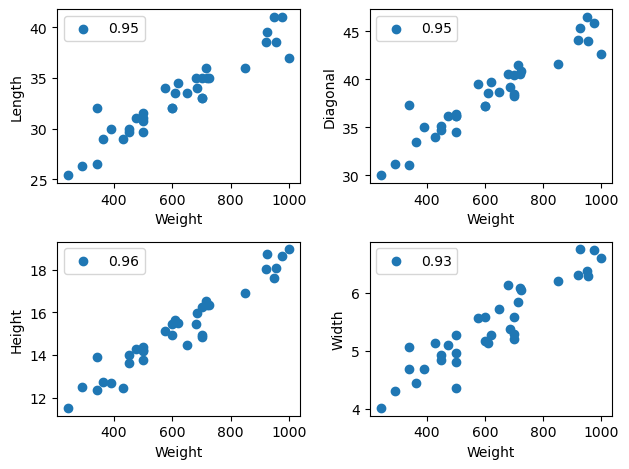

In [325]:
print_feature(2, 2, dataDF, dataDF.columns[0], dataDF.columns[1:], corrList[1:])

# 이쁜 형태로 선형관계가 보인다
# 이제 모델을 만들어보자!

(3) 학습 준비 <hr>
- 학습 알고리즘 : 양의 선형관계 파악됨 => 선형 모델
- 학습 데이터 준비 : 피처 - 타겟 분리, 학습용 데이터셋 - 테스트용 데이터셋
- 스케일링 왜 함? ==> 피쳐들 사이의 값의 범위의 차이가 클때 해줌!
- 피쳐 값의 범위 비교 : 작은 범위의 최대값 8 <~> 큰 범위 최대값 50 ===> 피처 스케일링해주자

(3-1) 학습 데이터 분리 => 피쳐 - 타겟, 학습용 데이터 셋 - 테스트용 데이터셋

In [326]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [327]:
# 피처와 타겟 분리
featureDF = dataDF[dataDF.columns[1:]]
featureDF.head(2)

Length  Diagonal  Height   Width
0    25.4      30.0   11.52  4.0200
1    26.3      31.2   12.48  4.3056

In [328]:
targetDF = dataDF[dataDF.columns[0]]
targetDF.head(2)

0    242
1    290
Name: Weight, dtype: int64

In [329]:
# 데이터셋 준비
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size = 0.3, random_state = 10)
# - random_state는 주고 싶은 값 주면 됨
# - 기본 사이즈 비율은 75:25, 설정하고 싶다면 파라미터에 값을 부여하면 된다.
#   여기서는 test를 0.3으로 하자, 그러면 자동으로 train은 1-0.3인 0.7이 된다.
# - 분류 라면 표본을 섞어줘야하기때문에 stratify를 해야하지만 이거는 선형모델이라 필요없다.

In [330]:
print(f'[훈련용] X_train : {X_train.shape}, y_train : {y_train.shape}')
print(f'[테스트용] X_test : {X_test.shape}, y_test : {y_test.shape}')

[훈련용] X_train : (24, 4), y_train : (24,)
[테스트용] X_test : (11, 4), y_test : (11,)


(3-2) 피처 스케일링  ==> 훈련 데이터로 생성

In [331]:
std_scaler = StandardScaler()
std_scaler.fit(X_train)

StandardScaler()

In [332]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)

MinMaxScaler()

In [333]:
rb_scaler = RobustScaler()
rb_scaler.fit(X_train)

RobustScaler()

In [334]:
# 3가지 버전으로 스케일링된 데이터셋 준비
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

X_train_mm = mm_scaler.transform(X_train)
x_test_mm = mm_scaler.transform(X_test)

X_train_rb = rb_scaler.transform(X_train)
X_test_rb = rb_scaler.transform(X_test)

(4) 학습 진행 <hr>

In [335]:
from sklearn.linear_model import LinearRegression

In [336]:
model = LinearRegression()
model.fit(X_train_std, y_train)

print(f"[모델 파라미터] \n - coef_ : {model.coef_} \n - intercept_ : {model.intercept_}")

# 왜 coef_는 4개가 나올까? 피쳐가 4개 니까 !
# y = L * model.coef_[0] + D * model.coef_[1] + ... +    ====> 이렇게 해서 계산해주는게 predict

[모델 파라미터] 
 - coef_ : [14.47599157 52.88038006 86.20924109 45.43621153] 
 - intercept_ : 677.125


(5) 모델 평가 <hr>
- 훈련용 데이터셋의 점수와 테스트 데이터셋 점수 비교
    * 훈련 점수 > 테스트 점수 : (그 갭이 크다면) 과대 적합
    * 훈련 점수 ▼ , 테스트 점수 ▼ : 과소 적합
    * 훈련 점수 ≒ 테스트 점수 : 최적 적합

In [337]:
train_score = model.score(X_train_std, y_train)
test_score = model.score(X_test_std, y_test)

print(f"train_score = {train_score} --- test_score = {test_score}")

# 그 차이가 큰지 작은지 어케 판별하냐? => 본인이 판단! 나는 더 꼼꼼하게 하겠다!라면 더 수정하든가 ~ 이정도도 ㄱㅊ하다면 킵고잉

train_score = 0.9483836242705043 --- test_score = 0.8382943580729838


3가지 방식으로 전처리된 걸로 학습을 시켜보자
- 함수로 만들어봄 (전처리 방식을 다르게 한 3가지 데이터 셋을 넣기 > 훈련 > 검사 )

In [338]:
# 이때는 모델이 총 3개의 모델이 만들어져야한다. 즉, 서로 다른 객체의 모델이 만들어져야 한다.
# 모델 1개당 스케일러 1개만! (1개의 모델에 스케일러를 여러번을 하면 스케일이 덮어씌워진다

test_dict = {}

def train_variety(scale_type):
    scaler = scale_type
    scaler.fit(X_train)
    scaled_X_train = scaler.transform(X_train)
    scaled_X_test = scaler.transform(X_test)

    model = LinearRegression()
    model.fit(scaled_X_train, y_train)
    print(f"[모델 파라미터] \n - coef_ : {model.coef_} \n - intercept_ : {model.intercept_}\n")
    
    train_score = model.score(scaled_X_train, y_train)
    test_score = model.score(scaled_X_test, y_test)
    print(f"[score 비교] \n  train_score = {train_score} --- test_score = {test_score}")
    
    test_dict[scale_type] = test_score


In [339]:
train_variety(StandardScaler())

[모델 파라미터] 
 - coef_ : [14.47599157 52.88038006 86.20924109 45.43621153] 
 - intercept_ : 677.125

[score 비교] 
  train_score = 0.9483836242705043 --- test_score = 0.8382943580729838


In [340]:
train_variety(MinMaxScaler())

[모델 파라미터] 
 - coef_ : [ 58.64992101 216.09844352 333.90902722 181.9246653 ] 
 - intercept_ : 228.99056285357727

[score 비교] 
  train_score = 0.9483836242705043 --- test_score = 0.8382943580729829


In [341]:
train_variety(RobustScaler())

[모델 파라미터] 
 - coef_ : [ 19.73795418  73.99734581 122.5197393   72.50128115] 
 - intercept_ : 652.0474639351822

[score 비교] 
  train_score = 0.9483836242705043 --- test_score = 0.8382943580729836


In [342]:
# 1차방정식을 생각하고 왜 함수를 돌릴때마다 모델 파라미터가 다를까라고 생각했는데, 여기는 피처가 4개이다. 그래서 1차방정식이라고 생각하면 안됨

In [343]:
test_dict

{StandardScaler(): 0.8382943580729838,
 MinMaxScaler(): 0.8382943580729829,
 RobustScaler(): 0.8382943580729836}

In [344]:
print("안녕하세요 임 쏘영씨 사랑해요 임 쏘영씨 위아원♥♥♥")
# - 옒 핸드 - 

안녕하세요 임 쏘영씨 사랑해요 임 쏘영씨 위아원♥♥♥
